In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
%cd ..

/scratch/km817/New_iREC/iREC


In [10]:
# load modules
import torch
import torch.distributions as dist
import pickle as pkl
import matplotlib.pyplot as plt
from models.SimpleBayesianLinRegressor import BayesLinRegressor
from rec.utils import compute_variational_posterior
#import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'lines.linewidth' : 2})
%config InlineBackend.figure_format='retina'

In [11]:
%matplotlib inline

In [56]:
def create_blr_problem(dim, seed):
    if dim in [2, 5]:
        signal_std = 1e-3
    else:
        signal_std = 1e-1
    torch.set_default_tensor_type(torch.DoubleTensor)
    blr = BayesLinRegressor(prior_mean=torch.zeros(dim),
                            prior_alpha=1,
                            signal_std=signal_std,
                            num_targets=100,
                            seed=seed)
    blr.sample_feature_inputs()
    blr.sample_regression_targets()
    blr.posterior_update()
    target = blr.weight_posterior
    return blr, target

In [57]:
def compute_preds(d, blr_obj):
    preds = torch.zeros([0])
    sample_list = torch.tensor(d['compressed_samples'])
    for s in sample_list:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

In [58]:
def true_preds(blr_obj):
    samples = blr_obj.weight_posterior.sample((50,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

In [59]:
def var_approx_preds(blr_obj):
    samples = compute_variational_posterior(blr_obj.weight_posterior).sample((50,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

# Point Estimate Results

## MSE

In [297]:
epsilons = [0., 0.05, 0.1, 0.15, 0.2]
dim = 90
beamwidths = [1, 5, 20]
results = []
hard = False
for beamwidth in beamwidths:
    beam_res = []
    for eps in epsilons:
        beam_res.append(pkl.load(open(f"PickledStuff/CorrelatedApprox/Dim{dim}/Variational_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))
    results.append(beam_res)

In [298]:
blr_seed = 1
b, t = create_blr_problem(dim=dim, seed=blr_seed)

In [299]:
full_preds = torch.zeros(len(beamwidths), len(epsilons), 50, len(b.regression_targets_test))
for j, _ in enumerate(beamwidths):
    for i, _ in enumerate(epsilons):
        full_preds[j, i] = compute_preds(results[j][i], b)

In [300]:
q = torch.tensor([0.25, 0.5, 0.75])
rmse = torch.quantile(torch.sqrt(torch.mean((full_preds - b.regression_targets_test) ** 2, dim=-1)), q, dim=-1)
mae = torch.quantile(torch.mean(torch.abs(full_preds - b.regression_targets_test), dim=-1), q, dim=-1)

In [301]:
mean_rmse_map = torch.sqrt(torch.mean((b.empirical_prediction(t.mean) - b.regression_targets_test) ** 2))

mean_mae_map = torch.mean(torch.abs(b.empirical_prediction(t.mean) - b.regression_targets_test))

In [302]:
torch.mean((full_preds - b.regression_targets_test) ** 2, dim=-1).shape

torch.Size([3, 5, 50])

In [303]:
rmse

tensor([[[2.2090, 2.1662, 2.1716, 2.2123, 2.2162],
         [2.2450, 2.1679, 2.1953, 2.1756, 2.2151],
         [2.2429, 2.1915, 2.1796, 2.2130, 2.2108]],

        [[2.3996, 2.2820, 2.3037, 2.2613, 2.2422],
         [2.3909, 2.3396, 2.2716, 2.2512, 2.2428],
         [2.4048, 2.3479, 2.2671, 2.2432, 2.2397]],

        [[2.5767, 2.4623, 2.4375, 2.3273, 2.2933],
         [2.5576, 2.4709, 2.3904, 2.3437, 2.2742],
         [2.5580, 2.4954, 2.3902, 2.3498, 2.2786]]])

In [304]:
rmse = []
mae = []
for i, beam in enumerate(beamwidths):
    rmse.append(torch.quantile(torch.sqrt(torch.mean((full_preds[i] - b.regression_targets_test) ** 2, dim=2)), q, dim=1))
    mae.append(torch.quantile(torch.mean(torch.abs(full_preds[i] - b.regression_targets_test), dim=2), q, dim=1))

In [305]:
def percentage_dropoff(stat, exact_stat, neg=False):
    if neg:
        diff = stat - exact_stat
        return 100 + (diff / exact_stat) * 100
    else:
        diff = stat - exact_stat
        return 100 - (diff / exact_stat) * 100

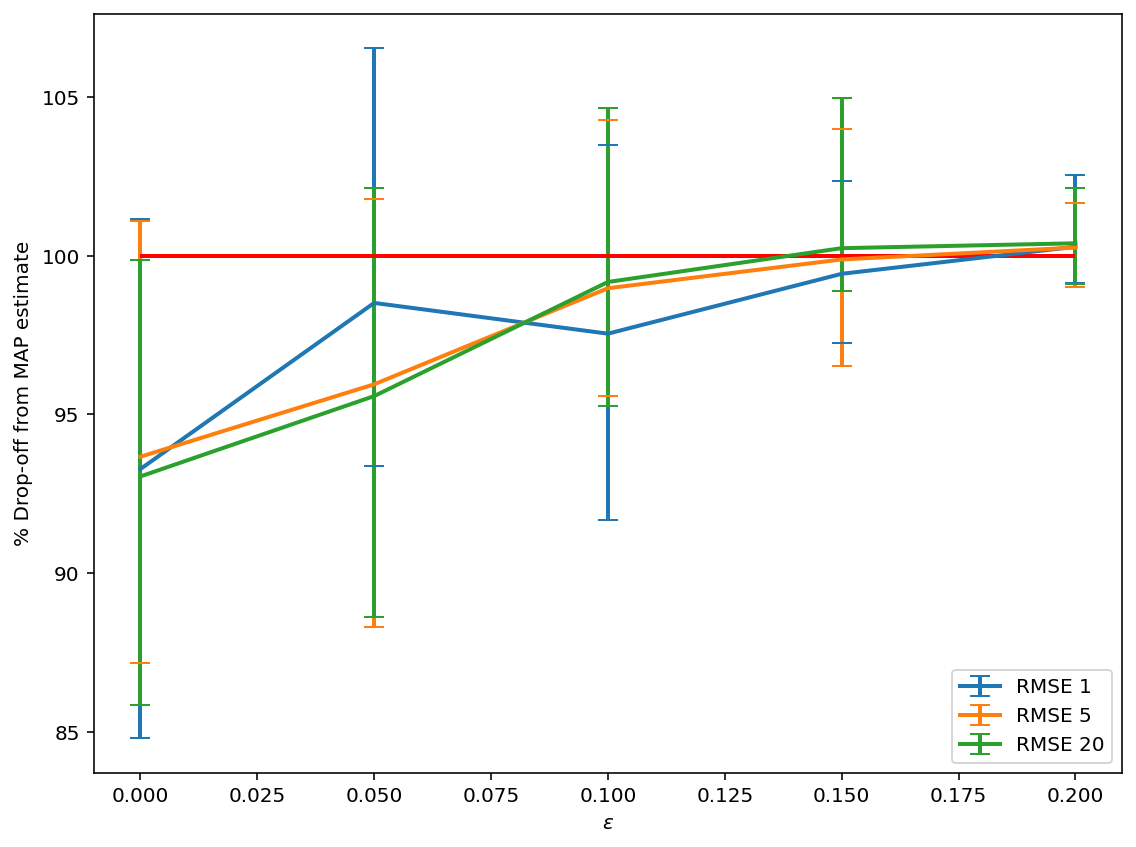

In [306]:
fig, ax = plt.subplots(1, figsize=(8,6))
for x, z in zip(rmse, beamwidths):
    ax.errorbar(epsilons, percentage_dropoff(x, mean_rmse_map)[1], capsize=5, 
                yerr= torch.abs(percentage_dropoff(x, mean_rmse_map) - percentage_dropoff(x, mean_rmse_map)[1])[[0, -1]], label=f'RMSE {z}')
ax.hlines(100, xmin=epsilons[0], xmax=epsilons[-1], color='red')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('% Drop-off from MAP estimate')
ax.legend(loc='lower right')
fig.tight_layout()
#fig.savefig(f"Figures/RMSE_MAE/VAR_DIM{dim}_RMSE.jpg", dpi=250, bbox_inches='tight')

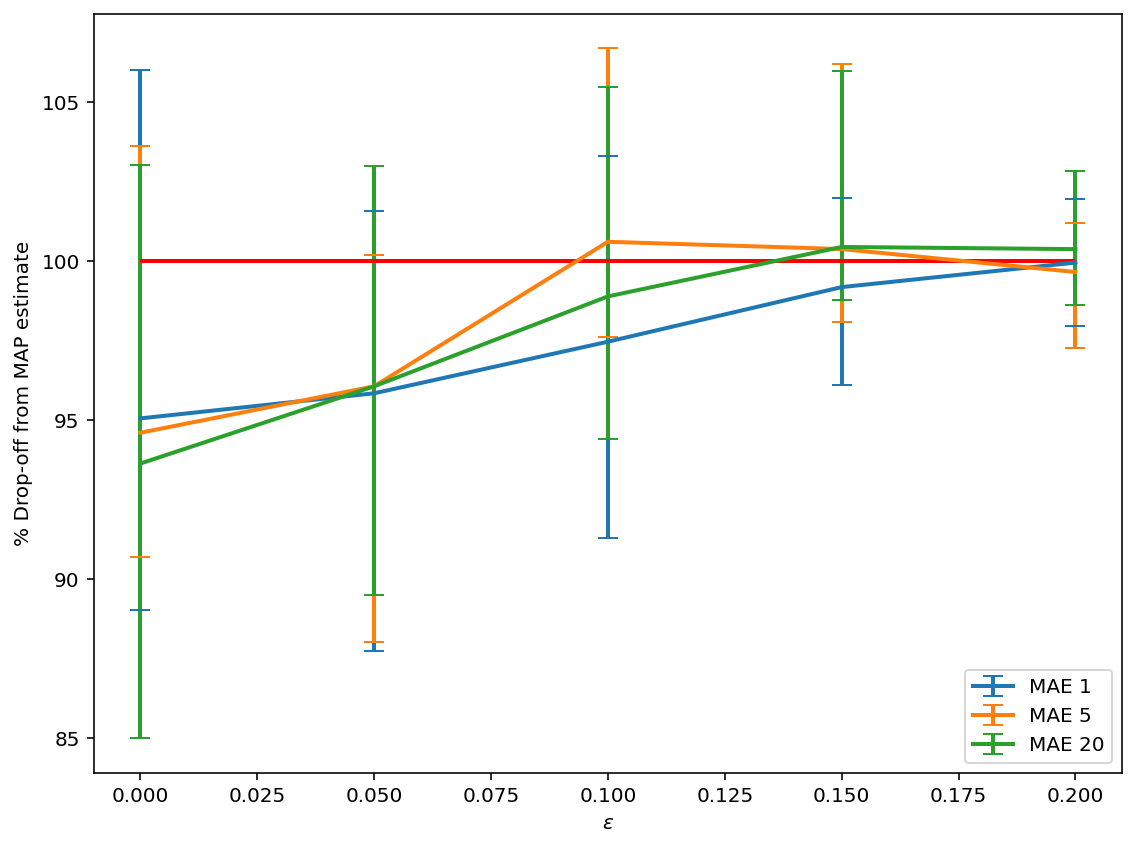

In [307]:
fig, ax = plt.subplots(1, figsize=(8,6))
for y, z in zip(mae, beamwidths):
    ax.errorbar(epsilons, percentage_dropoff(y, mean_mae_map)[1], capsize=5,
                yerr= torch.abs(percentage_dropoff(y, mean_mae_map) - percentage_dropoff(y, mean_mae_map)[1])[[0, -1]], label=f'MAE {z}')
ax.hlines(100, xmin=epsilons[0], xmax=epsilons[-1], color='red')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('% Drop-off from MAP estimate')
ax.legend(loc='lower right')
fig.tight_layout()
#fig.savefig(f"Figures/RMSE_MAE/VAR_DIM{dim}_MAE.jpg", dpi=250, bbox_inches='tight')

## Log-likelihood

In [308]:
log_likelihood = []

for i, beam in enumerate(beamwidths):
    log_likelihood.append(torch.quantile(torch.sum(dist.normal.Normal(loc=full_preds[i], scale=signal_std).log_prob(b.regression_targets_test), dim=2), q, dim=1))

In [309]:
map_log_likelihood = torch.sum(dist.normal.Normal(loc=b.empirical_prediction(t.mean), scale=signal_std).log_prob(b.regression_targets_test))

In [310]:
torch.sum(dist.normal.Normal(loc=b.empirical_prediction(b.true_sample), scale=1).log_prob(b.regression_targets_test))

tensor(-10.1531)

In [311]:
log_likelihood

[tensor([[-46.6251, -43.4568, -42.7861, -39.8977, -39.0333],
         [-41.7777, -38.7491, -39.2987, -38.2334, -37.7587],
         [-36.9477, -35.9162, -36.0445, -37.0267, -37.1228]]),
 tensor([[-46.0854, -43.6865, -41.5357, -40.3191, -38.5539],
         [-41.5486, -40.2140, -38.4884, -37.9821, -37.7730],
         [-37.8296, -35.9562, -36.6148, -36.1419, -37.0961]]),
 tensor([[-46.0979, -44.3569, -41.5307, -40.4781, -38.6644],
         [-41.9160, -40.4288, -38.3775, -37.7838, -37.6985],
         [-37.7772, -36.5223, -36.2368, -37.0435, -36.9898]])]

In [312]:
log_likelihood

[tensor([[-46.6251, -43.4568, -42.7861, -39.8977, -39.0333],
         [-41.7777, -38.7491, -39.2987, -38.2334, -37.7587],
         [-36.9477, -35.9162, -36.0445, -37.0267, -37.1228]]),
 tensor([[-46.0854, -43.6865, -41.5357, -40.3191, -38.5539],
         [-41.5486, -40.2140, -38.4884, -37.9821, -37.7730],
         [-37.8296, -35.9562, -36.6148, -36.1419, -37.0961]]),
 tensor([[-46.0979, -44.3569, -41.5307, -40.4781, -38.6644],
         [-41.9160, -40.4288, -38.3775, -37.7838, -37.6985],
         [-37.7772, -36.5223, -36.2368, -37.0435, -36.9898]])]

In [313]:
map_log_likelihood

tensor(-37.9137)

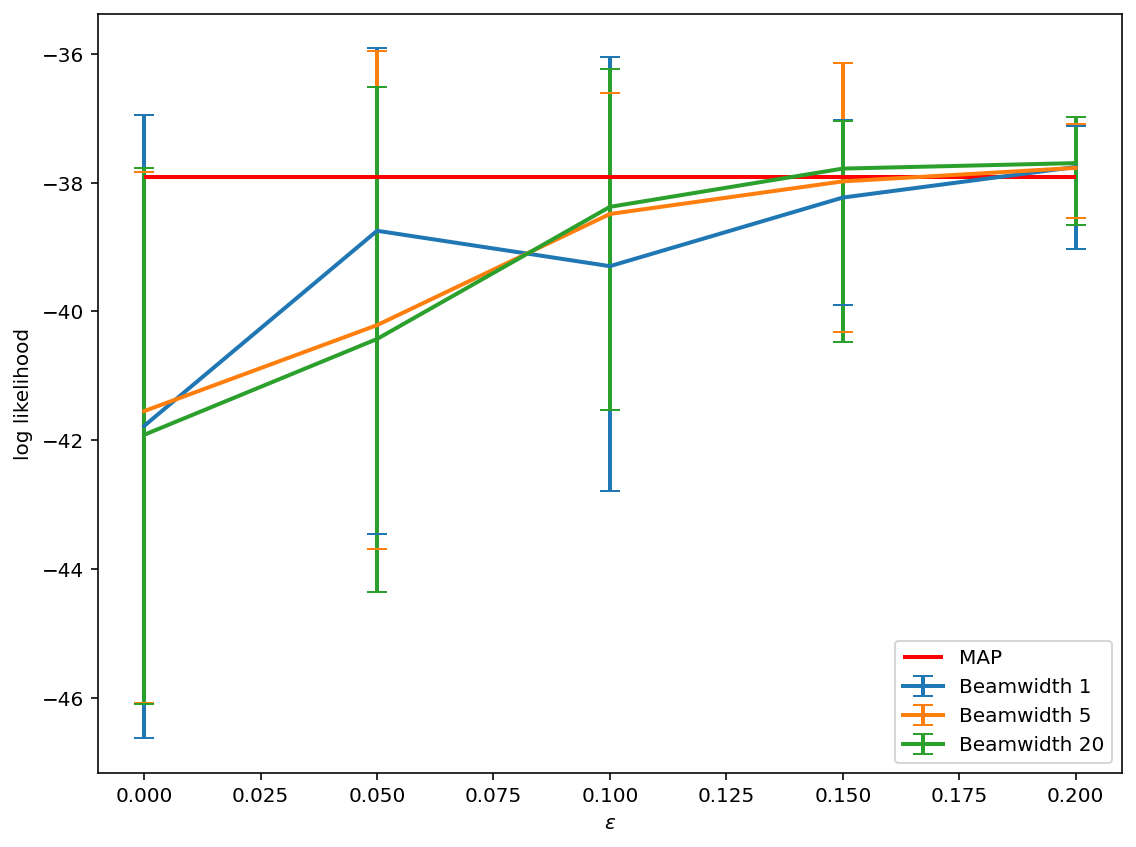

In [314]:
fig, ax = plt.subplots(1, figsize=(8,6))
for x, y in zip(log_likelihood, beamwidths):
    ax.errorbar(epsilons, x[1], capsize=5, 
                yerr = torch.abs(x - x[1])[[0, -1]], label=f'Beamwidth {y}')
ax.hlines(map_log_likelihood, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='MAP')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend(loc='lower right')
fig.tight_layout()
#fig.savefig(f"Figures/MAP_LIKELIHOOD/VAR_DIM{dim}.jpg", dpi=250, bbox_inches='tight')